# Build a VRT of partially overlapping tifs
This builds VRTs of GLiHT data by year and by UTM zone sorted by date (latest dates first)

Paul Montesano  
Sept 2023

In [1]:
!pip install rio-cogeo

Defaulting to user installation because normal site-packages is not writeable


In [6]:
!pip install earthaccess

Defaulting to user installation because normal site-packages is not writeable


In [1]:
from osgeo import gdal 
import glob
import pandas as pd
import geopandas as gpd
import rasterio
import contextily as ctx
import shapely

from collections import defaultdict

from dateutil.parser import parse
import datetime

import sys

sys.path.append('/home/pmontesa/code/icesat2_boreal/lib')
from rio_cogeo.cogeo import cog_translate
from rio_cogeo.profiles import cog_profiles

/tmp/ipykernel_629446/2577446676.py:4: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


# GLiHT on EarthData
## EarthData CMR search for GLiHT

Use DOI to search for metadata

In [4]:
import requests

In [8]:
cmrurl='https://cmr.earthdata.nasa.gov/search/' # CMR API base url - define the base url of NASA's CMR API as the variable `cmrurl`
doi = '10.3334/ORNLDAAC/2186'                   # ORNL DAAC - define the DOI as the variable `doi`
doi = '10.5067/Community/GLIHT/GLCHMT.001'
doisearch = cmrurl + 'collections.json?doi=' + doi
print('CMR URL: ' + doisearch)

CMR URL: https://cmr.earthdata.nasa.gov/search/collections.json?doi=10.5067/Community/GLIHT/GLCHMT.001


In [9]:
concept_id = requests.get(doisearch).json()['feed']['entry'][0]['id']
short_name = requests.get(doisearch).json()['feed']['entry'][0]['short_name']
print(concept_id)
print(short_name)

C2013348111-LPDAAC_ECS
GLCHMT


In [2]:
sys.path.append('/home/pmontesa/code/geoscitools')
import geoscilib

/panfs/ccds02/home/pmontesa/code/geoscitools/geoscilib.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [5]:
search_dict_alaska= {
    'site_name': 'Alaska',
    'bbox': [-170,45,-120,75], 
    'minmonth': "06",
    'maxmonth': "09",
    'years_list': [2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023]
}

geoscilib.COLLECTIONCONCEPTID_DICT

{'ATL08.003': 'C2003772626-NSIDC_ECS',
 'ATL08.005': 'C2144424132-NSIDC_ECS',
 'ATL08.006': 'C2565090645-NSIDC_ECS',
 'GLIHT': 'C2013348111-LPDAAC_ECS'}

In [8]:
search_dict = search_dict_alaska

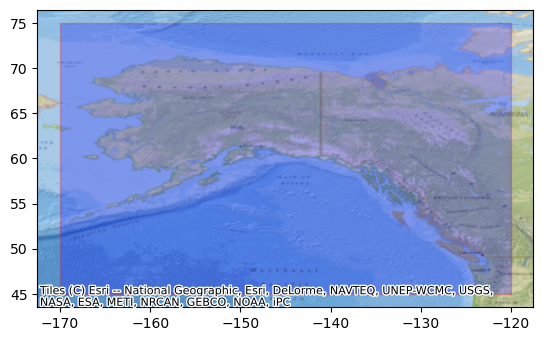

In [22]:
gdf = gpd.GeoDataFrame(index=[0], crs=4326,  geometry= [shapely.geometry.box(*search_dict['bbox'])])

ax = ctx.add_basemap(gdf.plot(facecolor="blue", alpha=0.25, ec='red'), crs=4326, 
        #source = ctx.providers.Gaode.Satellite
        #source = ctx.providers.Esri.WorldShadedRelief
        #source = ctx.providers.Esri.WorldGrayCanvas
        source = ctx.providers.Esri.NatGeoWorldMap
        #source = ctx.providers.Esri.WorldImagery
        #source = ctx.providers.Esri.DeLorme
    )

In [15]:
import importlib
importlib.reload(geoscilib)

<module 'geoscilib' from '/panfs/ccds02/home/pmontesa/code/geoscitools/geoscilib.py'>

In [16]:
# Page size: 150, number of results returned by page.
PAGESIZE = 150 
# Max page, number of pages to return before ending query.
MAXPAGE = 60
# Total max results will be PAGESIZE * MAXPAG

cmrP_list = []
for YEAR in search_dict['years_list']:
    
    cmrP = geoscilib.CmrProcess(mission = geoscilib.COLLECTIONCONCEPTID_DICT["GLIHT"], 
                      dateTime=f"{YEAR}-{search_dict['minmonth']}-01T00:00:00Z,{YEAR}-{search_dict['maxmonth']}-30T23:59:59Z", 
                      lonLat = ','.join(str(e) for e in search_dict['bbox']),
                      pageSize=PAGESIZE,
                      maxPages=MAXPAGE)
    cmrP_list.append(cmrP)

# Run search
resultList_year = [cmrP.run() for cmrP in cmrP_list]

Starting query
No hits on page number: 1, ending search.
No hits on page number: 2, ending search.
No hits on page number: 3, ending search.
Starting query
No hits on page number: 1, ending search.
No hits on page number: 2, ending search.
No hits on page number: 3, ending search.
Starting query
No hits on page number: 1, ending search.
No hits on page number: 2, ending search.
No hits on page number: 3, ending search.
Starting query
Results found on page: 1
Results found on page: 2
Results found on page: 3
No hits on page number: 4, ending search.
Starting query
No hits on page number: 1, ending search.
No hits on page number: 2, ending search.
No hits on page number: 3, ending search.
Starting query
Results found on page: 1
Results found on page: 2
Results found on page: 3
Results found on page: 4
Results found on page: 5
Results found on page: 6
Results found on page: 7
Results found on page: 8
Results found on page: 9
Results found on page: 10
Results found on page: 11
Results foun

In [23]:
dict_results = dict(zip(search_dict['years_list'], resultList_year))

In [27]:
print(f'# GLiHT granules by year for {search_dict["site_name"]}:')
[print(f'{YEAR}: {len(dict_results[YEAR])}') for YEAR in search_dict['years_list']]

# Get one large list with all years
gliht_granule_list = [item for sublist in resultList_year for item in sublist]
print(f"\n{len(gliht_granule_list)} total granules in search results list")

# GLiHT granules by year for Alaska:
2009: 0
2010: 0
2011: 0
2012: 368
2013: 0
2014: 3449
2015: 0
2016: 0
2017: 0
2018: 9000
2019: 0
2020: 0
2021: 0
2022: 0
2023: 0

12817 total granules in search results list


### Now you have a list of granules...ho to mosaic on fly?
earthaccess?

In [26]:
gliht_granule_list[-1]

'https://e4ftl01.cr.usgs.gov//GWELD1/COMMUNITY/GLCHMT.001/2018.07.31/GLCHMT_AK_20180730_FIA_52_l0s60_CHM.tif'

# GLiHT on ADAPT

## Find all files

In [2]:
GDAL_OPTIONS = "-of COG -co OVERVIEWS=IGNORE_EXISTING -co RESAMPLING=AVERAGE -co COMPRESS=DEFLATE -co PREDICTOR=3 -co BIGTIFF=IF_SAFER -co NUM_THREADS=10"

# Same as icesat2_boreal COGs
# Get the rio-cogeo profile for deflate compression, modify some of the options
dst_profile = cog_profiles.get("deflate")
dst_profile['blockxsize']=256
dst_profile['blockysize']=256
dst_profile['predictor']=3 # originally set to 2, which fails with 'int'; 1 tested successfully for 'int' and 'float64'
dst_profile['zlevel']=7

dst_profile

{'driver': 'GTiff', 'interleave': 'pixel', 'tiled': True, 'blockxsize': 256, 'blockysize': 256, 'compress': 'DEFLATE', 'predictor': 3, 'zlevel': 7}

In [3]:
MAINDIR = '/explore/nobackup/people/pmontesa/userfs02/data/gliht/chm'
YEAR = 2014
TYPE = 'CHM'
f_list = glob.glob(f'{MAINDIR}/{YEAR}/*{TYPE}.tif')

In [4]:
print(f'{f_list[2]}\n{f_list[2000]}')

/explore/nobackup/people/pmontesa/userfs02/data/gliht/chm/2014/AK_10Jul2014_l17s40_CHM.tif
/explore/nobackup/people/pmontesa/userfs02/data/gliht/chm/2014/AK_20140809_l4s604_CHM.tif


## Separate files in list according to the UTM zone of their coordinate system

In [5]:
%%time

list_utm_zones = ['32604','32605','32606','32607']

dict_utm_zones = defaultdict(list)

# Get lists of files for each UTM zone
for f in f_list:
    
    with rasterio.open(f) as ds:
        for zone in list_utm_zones:
            if str(ds.crs).split(':')[1] == zone: dict_utm_zones[zone].append(f) 

dict_utm_zones = dict(dict_utm_zones)

CPU times: user 5.65 s, sys: 18.6 s, total: 24.3 s
Wall time: 2min 1s


## Build a VRT with files of a specific UTM zone

#### functions

gdalbuildvrt -srcnodata "nan" -vrtnodata -9999 test4.vrt  /explore/nobackup/people/pmontesa/userfs02/data/gliht/chm/2014/AK_11Jul2014_l5s627_CHM.tif /explore/nobackup/people/pmontesa/userfs02/data/gliht/chm/2014/AK_11Jul2014_l5s628_CHM.tif

gdal_translate -of COG -co "OVERVIEWS=IGNORE_EXISTING" -co "RESAMPLING=AVERAGE" -co "COMPRESS=DEFLATE" -co "PREDICTOR=3" -co "BIGTIFF=IF_SAFER" -co "NUM_THREADS=10" test4.vrt test_cog4.tif


In [6]:
def clean_date(text):
    datetimestr = parse(text)
    #text = datetime.datetime.strptime(datetimestr, '%Y%m%d')
    return datetimestr

def filelist_to_date_sorted_df(f_list, date_string_position=1):
    
    '''
    Returns a df sorted by date
    This requires:
        that the date be at an expected position in the filename 
    '''
    
    df = pd.DataFrame(f_list, columns=['path'])
    df["file"] = df["path"].apply(lambda x: os.path.basename(x))

    # Handle date - this works with multiple
    df["date"] = df["file"].str.split('_', expand=True)[date_string_position]
    df['date'] = df['date'].apply(clean_date)
    df['date'] = pd.to_datetime(df['date']) 

    # Handle date - this works only with 1 date format
    #df["date"] = pd.to_datetime(df["path"].str.split('_', expand=True)[1] , format="%d%B%Y").dt.strftime('%Y%m%d')

    df = df.sort_values(by='date', ignore_index=True, ascending=False )
    
    return df

def build_mosaic(f_list, out_vrt_fn, GDAL_OPTIONS, DO_COG=True):
    
    vrt_options = gdal.BuildVRTOptions(resampleAlg='nearest', srcNodata='nan', VRTNodata=-9999)
    my_vrt = gdal.BuildVRT(out_vrt_fn, f_list, options=vrt_options)
    my_vrt = None
    
    if DO_COG:
        if True:
            ds = gdal.Translate(out_vrt_fn.replace('vrt','tif'), out_vrt_fn, options=GDAL_OPTIONS)
            ds = None
        else:    
            cog_translate(
                            out_vrt_fn,
                            # To avoid rewriting over the infile
                            out_vrt_fn.replace('vrt','tif'),
                            dst_profile,
                            add_mask=True,
                            #in_memory=True, # default processes in memory if small
                            quiet=False)
    else:
        print(f"Copy this to a forest VM:\ngdal_translate {GDAL_OPTIONS} {out_vrt_fn} {out_vrt_fn.replace('vrt','tif')}")

    print(out_vrt_fn)
    print(out_vrt_fn.replace('vrt','tif'))

def dict_gliht_to_mosaic(f_list, epsg_utm, GDAL_OPTIONS, date_string_position=1, DO_COG=True): 
    
    print(epsg_utm)
    error_list = []
    
    try:
        # Run function to sort
        df = filelist_to_date_sorted_df(f_list, date_string_position=date_string_position)
        utm_zone_specific_f_list = df.path.to_list()
        
        out_vrt_fn = os.path.join(MAINDIR, f'gliht_{TYPE.lower()}_{YEAR}_{epsg_utm}.vrt')
        
        build_mosaic(utm_zone_specific_f_list, out_vrt_fn, GDAL_OPTIONS, DO_COG=DO_COG)
        
    except Exception as e:
        print(e)
        error_list.append(e)
        
    return error_list    

#### Run the gliht to VRT function by UTM zone and collect the errors

In [7]:
dict_utm_zones_error = defaultdict(list)

for epsg_utm, f_list in dict_utm_zones.items():
    
    error_list = dict_gliht_to_mosaic(f_list, epsg_utm, GDAL_OPTIONS, date_string_position=1, DO_COG=False)
    
    # Errors get collected here by UTM zone
    dict_utm_zones_error[epsg_utm].append(error_list)

32607
Copy this to a forest VM:
gdal_translate -of COG -co OVERVIEWS=IGNORE_EXISTING -co RESAMPLING=AVERAGE -co COMPRESS=DEFLATE -co PREDICTOR=3 -co BIGTIFF=IF_SAFER -co NUM_THREADS=10 /explore/nobackup/people/pmontesa/userfs02/data/gliht/chm/gliht_chm_2014_32607.vrt /explore/nobackup/people/pmontesa/userfs02/data/gliht/chm/gliht_chm_2014_32607.tif
/explore/nobackup/people/pmontesa/userfs02/data/gliht/chm/gliht_chm_2014_32607.vrt
/explore/nobackup/people/pmontesa/userfs02/data/gliht/chm/gliht_chm_2014_32607.tif
32606
Unknown string format: Creek
32605
Copy this to a forest VM:
gdal_translate -of COG -co OVERVIEWS=IGNORE_EXISTING -co RESAMPLING=AVERAGE -co COMPRESS=DEFLATE -co PREDICTOR=3 -co BIGTIFF=IF_SAFER -co NUM_THREADS=10 /explore/nobackup/people/pmontesa/userfs02/data/gliht/chm/gliht_chm_2014_32605.vrt /explore/nobackup/people/pmontesa/userfs02/data/gliht/chm/gliht_chm_2014_32605.tif
/explore/nobackup/people/pmontesa/userfs02/data/gliht/chm/gliht_chm_2014_32605.vrt
/explore/nobac

#### Handle the UTM zone with a f_list for which an error popped up

##### Bonanza Creek data format is special: no full date string

In [8]:
dict_utm_zones_error = dict(dict_utm_zones_error)

for epsg_utm, error_list_list in dict_utm_zones_error.items():
    
    print(epsg_utm)
    
    for error_list in error_list_list:
        for e in error_list:
            
            # Get the unexpected string returned from the position of the gliht filename that you thought held the datestring
            unexpected_string = e.args[1]
            print(unexpected_string)
            
            # Get the files in this zone's list where the unexpectected string was NOT in (the normally formatted filenames)
            gen = filter(lambda x: unexpected_string not in x, dict_utm_zones[epsg_utm]) #Returns a generator
            f_list_expected = list(gen)
            
            gen = filter(lambda x: unexpected_string in x, dict_utm_zones[epsg_utm]) #Returns a generator
            f_list_unexpected = list(gen)
            
            # Get the sorted df from this 'expected' filename list
            df_exp = filelist_to_date_sorted_df(f_list_expected, date_string_position=1)
            
            # Get the sorted df from the 'unexpected' filename list
            df_unexp = filelist_to_date_sorted_df(f_list_unexpected, date_string_position=3)
            
            # Now sort just according to filename
            # In this specific case this will sort Bonanza Creek flightlines according to kHz of acquisition (larger first)
            df_unexp.sort_values(by='file', ignore_index=True, ascending=False, inplace=True )
            
            # Combine the 2 dfs
            df = pd.concat([df_exp, df_unexp])
            
            utm_zone_specific_f_list = df.path.to_list()
        
            out_vrt_fn = os.path.join(MAINDIR, f'gliht_{TYPE.lower()}_{YEAR}_{epsg_utm}.vrt')
        
            build_mosaic(utm_zone_specific_f_list, out_vrt_fn, GDAL_OPTIONS, DO_COG=False)
            
            #ds = gdal.Translate(out_vrt_fn.replace('vrt','tif'), out_vrt_fn, options=GDAL_OPTIONS)
            #ds = None
            
            
    

32607
32606
Creek
Copy this to a forest VM:
gdal_translate -of COG -co OVERVIEWS=IGNORE_EXISTING -co RESAMPLING=AVERAGE -co COMPRESS=DEFLATE -co PREDICTOR=3 -co BIGTIFF=IF_SAFER -co NUM_THREADS=10 /explore/nobackup/people/pmontesa/userfs02/data/gliht/chm/gliht_chm_2014_32606.vrt /explore/nobackup/people/pmontesa/userfs02/data/gliht/chm/gliht_chm_2014_32606.tif
/explore/nobackup/people/pmontesa/userfs02/data/gliht/chm/gliht_chm_2014_32606.vrt
/explore/nobackup/people/pmontesa/userfs02/data/gliht/chm/gliht_chm_2014_32606.tif
32605
